In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score

import sys, importlib
from scripts.classes import Label, Sample
import scripts.util as util
importlib.reload(sys.modules['scripts.util'])
importlib.reload(sys.modules['scripts.classes'])


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

DIVIDER = "-------------------------------"

Num GPUs Available:  1


# Data loading step

In [3]:
TRAIN_DATA = "../data/EuroSatData/train.csv"
TEST_DATA = "../data/EuroSatData/test.csv"
VALIDATION_DATA = "../data/EuroSatData/validation.csv"
BLANK_MODEL = "../data/blank_vgg16.h5"
MAIN_MODEL = "../data/trained_vgg16.h5"

# Load data into pandas dataframe from csv files
train_df = pd.read_csv(TRAIN_DATA)
train_df["Filename"] = "../data/EuroSatData/" + train_df["Filename"].astype(str)
test_df = pd.read_csv(TEST_DATA)
test_df["Filename"] = "../data/EuroSatData/" + test_df["Filename"].astype(str)
validation_df = pd.read_csv(VALIDATION_DATA)
validation_df["Filename"] = "../data/EuroSatData/" + validation_df["Filename"].astype(str)

In [4]:
# Load image data into new column called "Image"
train_df["Image"] = train_df["Filename"].apply(util.read_img)
test_df["Image"] = test_df["Filename"].apply(util.read_img)
validation_df["Image"] = validation_df["Filename"].apply(util.read_img)

In [5]:
# Prepare the x and y of each data set
x_train, y_train = util.pd_series_to_tensor(train_df["Image"]), train_df["Label"].values
x_test, y_test = util.pd_series_to_tensor(test_df["Image"]), test_df["Label"].values
x_validation, y_validation = util.pd_series_to_tensor(validation_df["Image"]), validation_df["Label"].values

# Model set up and training

In [6]:
pretrained_vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(64, 64, 3))

In [7]:
pretrained_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [8]:
model = tf.keras.Sequential()

In [9]:
# Ignore the last layer, which is the dense layers
for layer in pretrained_vgg16.layers:
  layer.trainable = False
  model.add(layer)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

In [11]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=10))
model.add(tf.keras.layers.Activation("softmax"))

In [12]:
model.summary()
model.save(BLANK_MODEL)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

In [13]:
EPOCHS = 6
BATCH_SIZE = 16
LR = 0.001
model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=LR), 
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"]
)




In [14]:
# NOTE: Possible batch_size configuration
train_history = model.fit(x=x_train, y=y_train, validation_data=(x_validation, y_validation), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

Epoch 1/6
1182/1182 - 36s - loss: 0.7516 - accuracy: 0.7521 - val_loss: 0.5708 - val_accuracy: 0.8120 - 36s/epoch - 30ms/step
Epoch 2/6
1182/1182 - 14s - loss: 0.4872 - accuracy: 0.8371 - val_loss: 0.4895 - val_accuracy: 0.8344 - 14s/epoch - 12ms/step
Epoch 3/6
1182/1182 - 13s - loss: 0.4240 - accuracy: 0.8559 - val_loss: 0.4469 - val_accuracy: 0.8483 - 13s/epoch - 11ms/step
Epoch 4/6
1182/1182 - 13s - loss: 0.3819 - accuracy: 0.8718 - val_loss: 0.4162 - val_accuracy: 0.8607 - 13s/epoch - 11ms/step
Epoch 5/6
1182/1182 - 16s - loss: 0.3554 - accuracy: 0.8805 - val_loss: 0.4074 - val_accuracy: 0.8641 - 16s/epoch - 13ms/step
Epoch 6/6
1182/1182 - 67s - loss: 0.3350 - accuracy: 0.8886 - val_loss: 0.3985 - val_accuracy: 0.8624 - 67s/epoch - 57ms/step


In [15]:
model.save(MAIN_MODEL)

In [16]:
# Show train losses and accuracy here
train_losses = train_history.history["loss"]
train_accuracy = train_history.history["accuracy"]
val_losses = train_history.history["val_loss"]
val_accuracy = train_history.history["val_accuracy"]

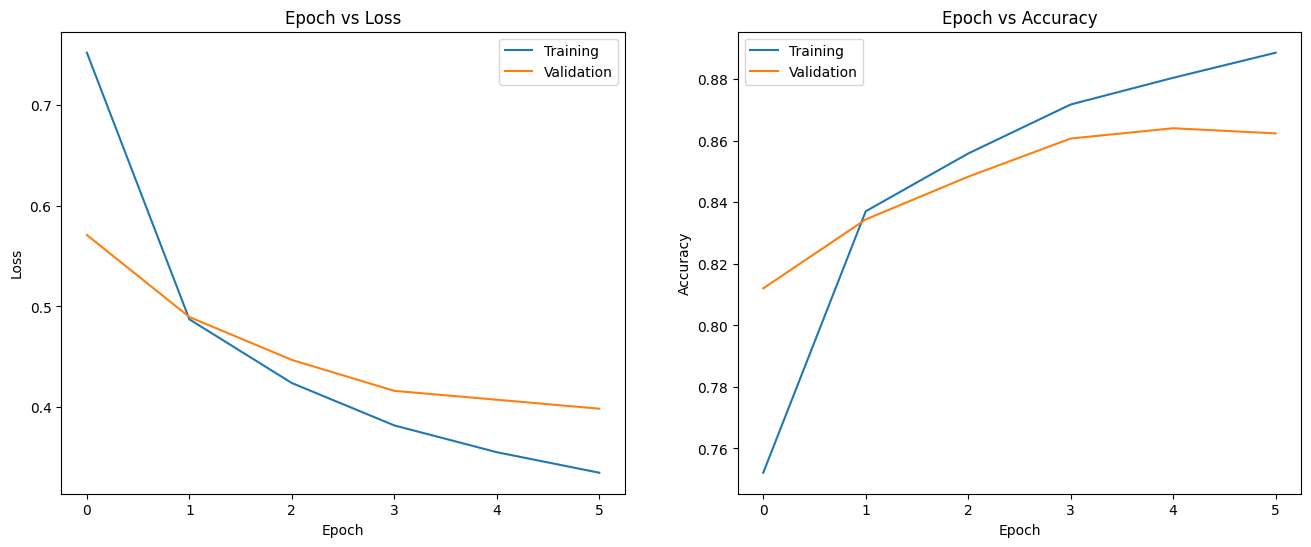

In [17]:
plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(np.arange(0, EPOCHS, 1))
plt.legend(["Training", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, EPOCHS, 1))
plt.legend(["Training", "Validation"])

plt.show()


In [18]:
# NOTE: Possible batch_size configuration
prediction = model.predict(x=x_test, verbose=2)
y_prediction = np.argmax(prediction, axis=1)

85/85 - 3s - 3s/epoch - 34ms/step


In [19]:
correct = y_test == y_prediction
test_accuracy = np.sum(correct)/len(y_test)
p_score = precision_score(y_true=y_test, y_pred=y_prediction, average="micro")
r_score = recall_score(y_true=y_test, y_pred=y_prediction, average="micro")
conf_matrix = confusion_matrix(y_test, y_prediction)

In [20]:
print(f"Accuracy: {test_accuracy*100}%")

Accuracy: 87.0%


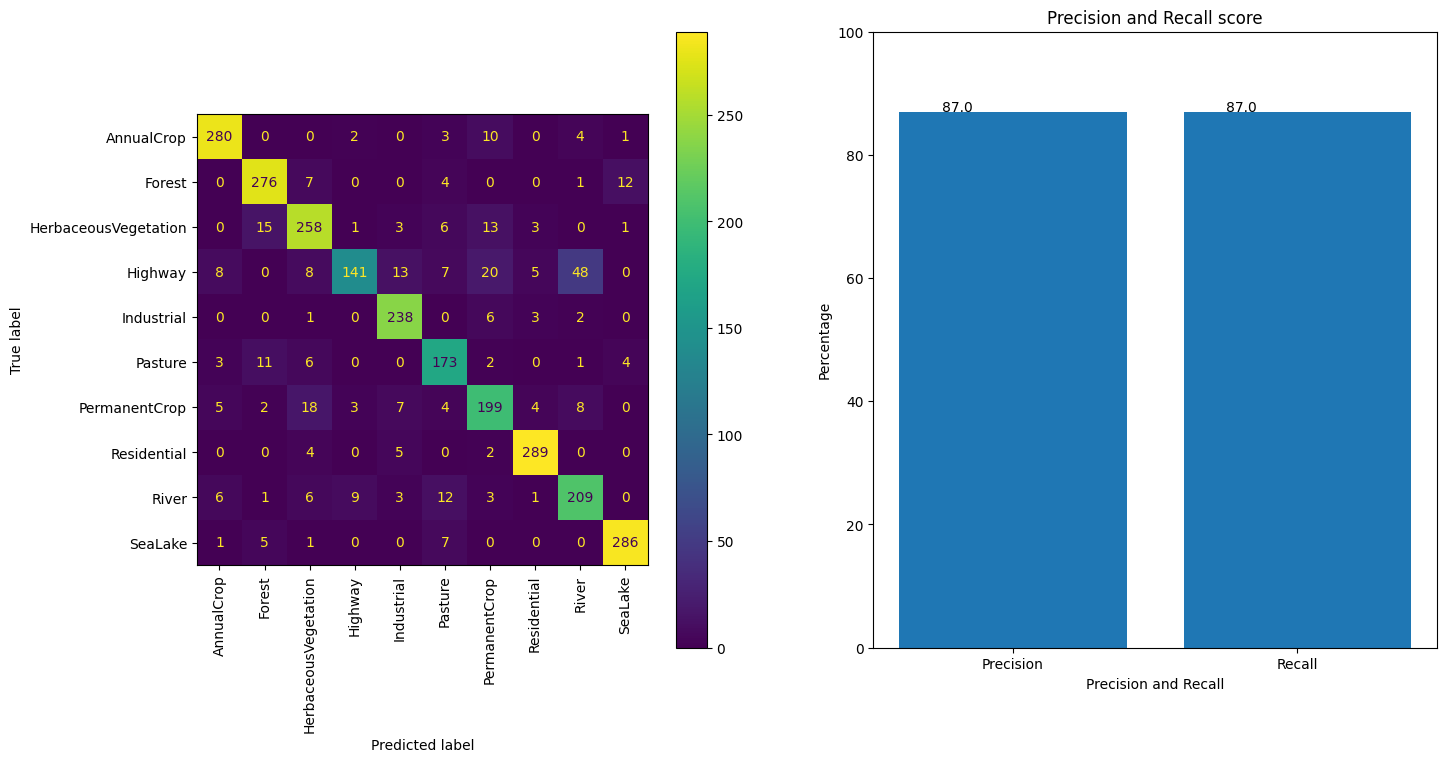

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_prediction, display_labels=Label.label_mappings(), xticks_rotation="vertical", ax=axes[0])
util.plot_recall_precision(axes[1], p_score, r_score)


# Hyperparameter study

In [22]:
hyperparameters = {
  "epochs": [10, 10, 8, 5, 15],
  "batch_size": [BATCH_SIZE, 32, 64, 128, 128],
  "lr": [LR, LR, 0.0001, 0.00001, LR]
}
histories = []
predictions = []
num_sweeps = len(hyperparameters["epochs"])

assert len(hyperparameters["epochs"]) == len(hyperparameters["batch_size"]) and len(hyperparameters["batch_size"]) == len(hyperparameters["lr"])
print (num_sweeps)

5


In [85]:
for sweep in range(num_sweeps):
  print(f"*{DIVIDER}Hyperparameter sweep number {sweep+1}/{num_sweeps}{DIVIDER}*")
  sweep_epoch = hyperparameters["epochs"][sweep]
  sweep_batch_size = hyperparameters["batch_size"][sweep]
  sweep_lr = hyperparameters["lr"][sweep]

  sweep_model = tf.keras.models.load_model(BLANK_MODEL)
  sweep_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=sweep_lr), 
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
  )
  sweep_history = sweep_model.fit(x=x_train, y=y_train, validation_data=(x_validation, y_validation), batch_size=sweep_batch_size, epochs=sweep_epoch, verbose=1)
  histories.append(sweep_history)

*-------------------------------Hyperparameter sweep number 1/5-------------------------------*
Epoch 1/10
1182/1182 [==============================] - 16s 13ms/step - loss: 0.7507 - accuracy: 0.7524 - val_loss: 0.5559 - val_accuracy: 0.8130
Epoch 2/10
1182/1182 [==============================] - 15s 13ms/step - loss: 0.4885 - accuracy: 0.8377 - val_loss: 0.4882 - val_accuracy: 0.8324
Epoch 3/10
1182/1182 [==============================] - 14s 12ms/step - loss: 0.4223 - accuracy: 0.8583 - val_loss: 0.4468 - val_accuracy: 0.8498
Epoch 4/10
1182/1182 [==============================] - 16s 14ms/step - loss: 0.3816 - accuracy: 0.8721 - val_loss: 0.4482 - val_accuracy: 0.8515
Epoch 5/10
1182/1182 [==============================] - 16s 14ms/step - loss: 0.3551 - accuracy: 0.8809 - val_loss: 0.4288 - val_accuracy: 0.8537
Epoch 6/10
1182/1182 [==============================] - 15s 12ms/step - loss: 0.3336 - accuracy: 0.8906 - val_loss: 0.3913 - val_accuracy: 0.8687
Epoch 7/10
1182/1182 [======

In [92]:
histories = histories[5:]

In [57]:
def plot_stats(axis, stats1, stats2, stats1label, stats2label, title, xlabel, ylabel):
  axis.plot(stats1, label=stats1label)
  axis.plot(stats2, label=stats2label)
  axis.set_title(title, loc="center", wrap=True)
  axis.set_xlabel(xlabel)
  axis.set_ylabel(ylabel)
  axis.legend()

In [86]:
for sweep in range(num_sweeps):
  sweep_epoch = hyperparameters["epochs"][sweep]
  sweep_lr = hyperparameters["lr"][sweep]
  sweep_batch_size = hyperparameters["batch_size"][sweep]
  print(f"{DIVIDER}Sweep {sweep+1} Hyperparameters{DIVIDER}")
  print(f"Epochs: {sweep_epoch} | Learning Rate: {sweep_lr} | Batch Size: {sweep_batch_size}")
  print()

-------------------------------Sweep 1 Hyperparameters-------------------------------
Epochs: 10 | Learning Rate: 0.001 | Batch Size: 16

-------------------------------Sweep 2 Hyperparameters-------------------------------
Epochs: 10 | Learning Rate: 0.001 | Batch Size: 32

-------------------------------Sweep 3 Hyperparameters-------------------------------
Epochs: 8 | Learning Rate: 0.0001 | Batch Size: 64

-------------------------------Sweep 4 Hyperparameters-------------------------------
Epochs: 5 | Learning Rate: 1e-05 | Batch Size: 128

-------------------------------Sweep 5 Hyperparameters-------------------------------
Epochs: 15 | Learning Rate: 0.001 | Batch Size: 128



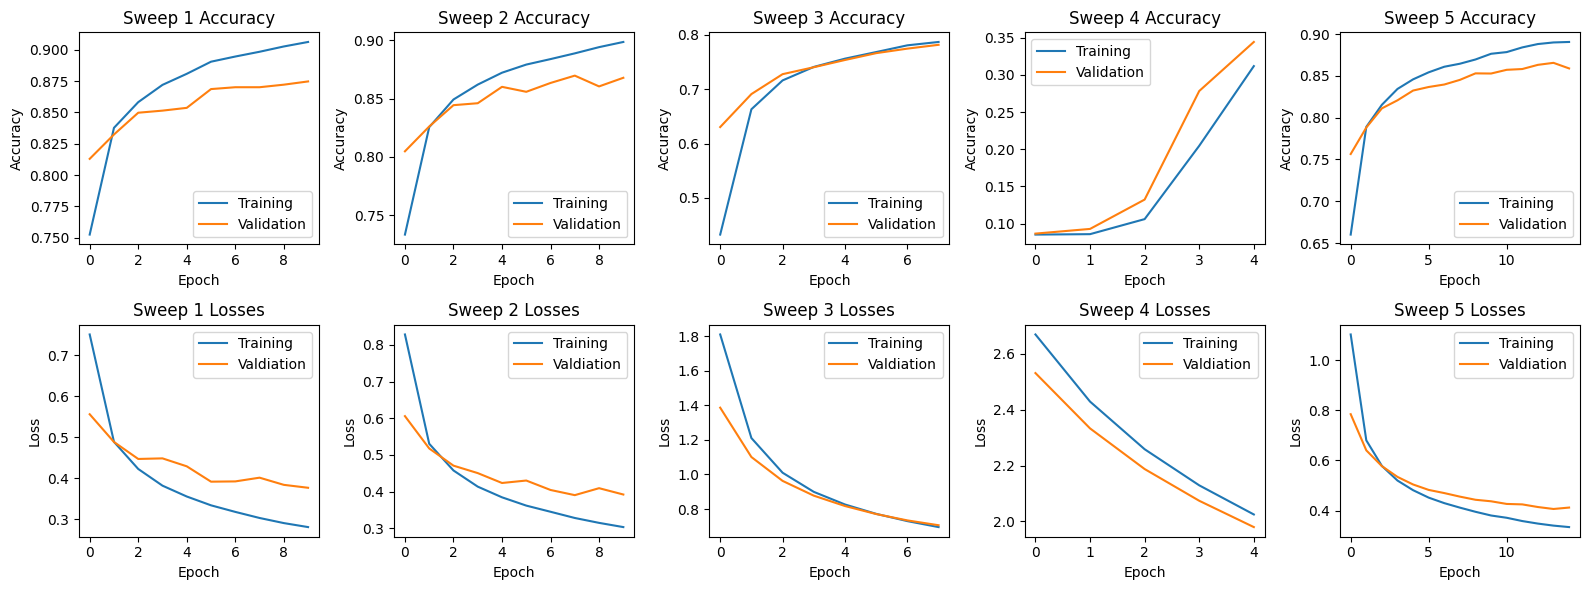

In [93]:
# Plot of accuracy vs losses
fig, ax = plt.subplots(2, 5, figsize=(16, 6))
"""
train_losses = train_history.history["loss"]
train_accuracy = train_history.history["accuracy"]
val_losses = train_history.history["val_loss"]
val_accuracy = train_history.history["val_accuracy"]
"""
for sweep in range(num_sweeps):
  sweep_epoch = hyperparameters["epochs"][sweep]
  sweep_lr = hyperparameters["lr"][sweep]
  sweep_batch_size = hyperparameters["batch_size"][sweep]
  sweep_history = histories[sweep]
  sweep_train_loss = sweep_history.history["loss"]
  sweep_train_accuracy = sweep_history.history["accuracy"]
  sweep_val_loss = sweep_history.history["val_loss"]
  sweep_val_accuracy = sweep_history.history["val_accuracy"]

  accuracy_plot_title = f"Sweep {sweep+1} Accuracy"
  loss_plot_title = f"Sweep {sweep+1} Losses"
  plot_stats(ax[0][sweep], sweep_train_accuracy, sweep_val_accuracy, "Training", "Validation", accuracy_plot_title, "Epoch", "Accuracy")
  plot_stats(ax[1][sweep], sweep_train_loss, sweep_val_loss, "Training", "Valdiation", loss_plot_title, "Epoch", "Loss")
fig.tight_layout()


Text(0.5, 1.0, 'Validation Loss of Sweeps')

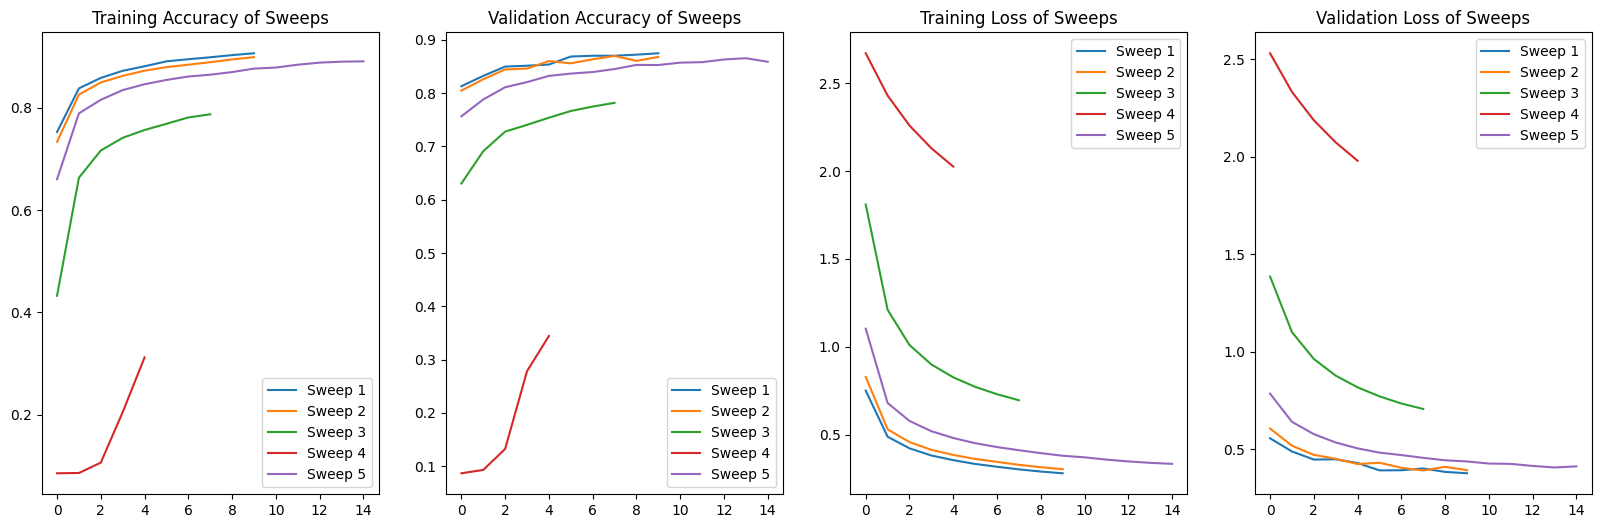

In [94]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

for sweep in range(num_sweeps):
  ax[0].plot(histories[sweep].history["accuracy"], label=f"Sweep {sweep+1}")
  ax[1].plot(histories[sweep].history["val_accuracy"], label=f"Sweep {sweep+1}")
  ax[2].plot(histories[sweep].history["loss"], label=f"Sweep {sweep+1}")
  ax[3].plot(histories[sweep].history["val_loss"], label=f"Sweep {sweep+1}")

for i in range(4):
  ax[i].legend()

ax[0].set_title("Training Accuracy of Sweeps")
ax[1].set_title("Validation Accuracy of Sweeps")
ax[2].set_title("Training Loss of Sweeps")
ax[3].set_title("Validation Loss of Sweeps")